<a href="https://colab.research.google.com/github/eeemile777/Prado_PageRank/blob/main/Prado_PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 **Analyzing Prado Museum Paintings with PageRank**

This project applies **three variations of the PageRank algorithm**—unweighted, weighted, and adjusted weighted—to rank paintings from the **Prado Museum** dataset. The relationships between paintings are defined based on **shared tags** and **shared authors**, offering insights into their interconnectedness and artistic influence.

## 📌 **Approach**

### **Graph Representation and PageRank Variations**
- **Nodes**: Represent individual paintings.
- **Edges**: Represent connections between paintings based on shared characteristics:
  1. **Unweighted Edges**: Simple binary connections where paintings share at least one tag, which ighlights general connectivity by treating all edges equally.

  2. **Weighted Edges**: The strength of a connection is the **number of shared tags**, which prioritizes paintings with stronger thematic (tag-based) links.

  3. **Adjusted Weighted Edges**: Adds **2 extra points** to the edge weight if the two paintings were created by the same author/artist, which combines shared tags and authorship to amplify artistic relationships.



## **Implementation**

To handle the computational demands of ranking relationships in a large dataset, **PySpark** was used. Its distributed computing capabilities ensured efficient graph construction and algorithm execution, providing a scalable solution for complex graph-based tasks.




---


# ⚙️ **1. Environment Setup**

Before diving into the analysis, let's set up the environment. This involves:

1. **Installing Required Libraries**: Ensuring PySpark is available and loading essential libraries for data manipulation, visualization, and Spark operations.
2. **Starting the Spark Session**: Initializing a Spark session to enable distributed computation for handling large-scale data.

In [ ]:
print("🔥 Installing PySpark...")
!pip install pyspark

# importing necessary libraries
print("📦 Importing libraries...")
print("📦 Importing libraries...")
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from collections import Counter
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import (
    monotonically_increasing_id,
    countDistinct,
    col,
    isnan,
    when,
    count,
    split,
    array_remove,
    collect_list,
    explode,
)
from pyspark.sql.types import *


print("✅ All libraries imported successfully!")

print("⚡ Starting the Spark session...")
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Prado Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


print("🚀 Spark session is up!")



🔥 Installing PySpark...
📦 Importing libraries...
✅ All libraries imported successfully!
⚡ Starting the Spark session...
🚀 Spark session is up!


---
# 📥 **2. Dataset Acquisition**

With the environment ready, the next step is to acquire the dataset. This involves:

1.  **Setting Up Kaggle Credentials**: Configuring access to Kaggle datasets by providing the required API credentials.
2.  **Downloading the Dataset**: Retrieving the [Prado Museum dataset from Kaggle](https://www.kaggle.com/datasets/maparla/prado-museum-pictures).
3.  **Unzipping the Dataset**: Extracting the relevant CSV files while excluding unnecessary images of paintings (e.g., large JPG files).


In [ ]:
print("🔑 Set up Kaggle credentials...")
os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

print("\n📥 Downloading the Prado Museum dataset...")
!kaggle datasets download -d maparla/prado-museum-pictures

print("\n📂 Unzipping the dataset... excluding JPG files")
!unzip prado-museum-pictures.zip -x "*.jpg"

🔑 Set up Kaggle credentials...

📥 Downloading the Prado Museum dataset...
Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
100% 24.9G/24.9G [03:15<00:00, 172MB/s]
100% 24.9G/24.9G [03:15<00:00, 137MB/s]

📂 Unzipping the dataset... excluding JPG files
Archive:  prado-museum-pictures.zip
  inflating: prado.csv               


---
# 📄 **3. Dataset Loading and Exploration**

The Prado Museum dataset, loaded into a **Spark DataFrame**, consists of **13,487 paintings** with metadata.

## **we noticeds**

   - No missing values in `work_tags`, `work_title`, and `author`, ensuring reliable analysis.  
   - Significant missing data in technical details (`technical_sheet_*`), likely to be excluded.
   - **2,560 unique authors**, highlighting the dataset's diversity.  
   - Most rows have unique `work_tags`, `work_title`, and `author`.



In [ ]:
print("📊 Loading the Prado dataset into a Spark DataFrame...")
prado_df = spark.read.csv('prado.csv', header=True, multiLine=True, escape='"')
print("✅ Dataset loaded successfully!")

print("🔍 Previewing the dataset:")
prado_df.show(3)

row_count = prado_df.count()
print(f"🧮 Dataset has {row_count} rows.")

📊 Loading the Prado dataset into a Spark DataFrame...
✅ Dataset loaded successfully!
🔍 Previewing the dataset:
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+----------------------------------+---------------------+----------------------+---------------------+-----------------------+-----------------------+-------------------------+---------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------------------+-----------------------+--------------------+----------------------+-----------------------------------+
|            work_url|      work_image_url|              author|          author_bio|          author_url|           author_id|          work_title|       work_subtitle|work_exposed|    work_de

In [ ]:
print("\n📝 Missing Values Count per Column:")
missing_values = prado_df.select(
    [(count(when(col(c).isNull() | isnan(c), c)).alias(c)) for c in prado_df.columns]
)
missing_values.show(truncate=False)

print("\n🔍 Unique Values Count per Column:")
unique_values = prado_df.agg(
    *[countDistinct(col(c)).alias(c) for c in prado_df.columns]
)
unique_values.show(truncate=False)


📝 Missing Values Count per Column:
+--------+--------------+------+----------+----------+---------+----------+-------------+------------+----------------+---------+----------------------------------+---------------------+----------------------+---------------------+-----------------------+-----------------------+-------------------------+---------------------+---------------------------+------------+---------+-----------+---------+-----------------------+--------------------------------+-----------------------+--------------------+----------------------+-----------------------------------+
|work_url|work_image_url|author|author_bio|author_url|author_id|work_title|work_subtitle|work_exposed|work_description|work_tags|technical_sheet_numero_de_catalogo|technical_sheet_autor|technical_sheet_titulo|technical_sheet_fecha|technical_sheet_tecnica|technical_sheet_soporte|technical_sheet_dimension|technical_sheet_serie|technical_sheet_procedencia|bibliography|inventory|expositions|ubication|te

---
# 🛠️ **Feature Engineering**

To prepare the dataset for graph-based analysis, the following steps were undertaken:

## **Unique ID**
Each painting was assigned a **unique, non-sequential ID** using PySpark's `monotonically_increasing_id()` function.

 Now every painting is uniquely identifiable, nodes in the graph will be represented as numeric values.

## **Extracting Relevant Columns**
Key columns were selected for their importance to the analysis:

1. **ID**: Unique numeric identifier for each painting.  
2. **Work Title**: Title of the artwork.  
3. **Author**: Name of the artist, important for author-adjusted-weights connections.
4. **Work Tags**: Descriptive attributes (e.g., techniques, materials, themes) that will be considered as the **links** between paintings, forming edges in the graph.


In [ ]:
print("🆔 Adding a unique (non-sequential) ID to each row using PySpark...")
prado_df_with_id = prado_df.withColumn("id", monotonically_increasing_id())
print("✅ Successfully added the unique ID column!")

print("\n🔍 Extracting 'id', 'work_title', 'author', and 'work_tags' columns...")
prado_tags_df = prado_df_with_id.select("id", "work_title", "author", "work_tags")

print("\n📊 First 5 Rows of Extracted Columns:")
prado_tags_df.show(5, truncate=False)


🆔 Adding a unique (non-sequential) ID to each row using PySpark...
✅ Successfully added the unique ID column!

🔍 Extracting 'id', 'work_title', 'author', and 'work_tags' columns...

📊 First 5 Rows of Extracted Columns:
+---+--------------------------------------------+----------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|id |work_title                                  |author                                  |work_tags                                                                                                                                         |
+---+--------------------------------------------+----------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |Cabeza de Gigante                           |Bayeu y Subías

---
# 👨‍🎨 **Author/Artist Exploration**

In this section, we examine the authors in the Prado Museum dataset and decide to add extra weight to connections between paintings by the same artist.

- **Top Authors**:  
  There are **2,560 unique authors** in the dataset. The majority of paintings are by **Anonymous painters (Anónimo)**, with **2,698 paintings**. The next most prolific artist is **Goya y Lucientes, Francisco de**, with **1,080 paintings**.

- **Adding Authorship Weight**:  
  We give an **extra weight of +2** to connections between paintings created by the same artist to emphasize their shared influence (this addition will be done later in edge construction part)






In [ ]:
print("\n🔍 Analyzing author data...")

# counting the number of paintings per author and sorting by count
author_paintings_count = prado_tags_df.groupBy("author").count().orderBy(col("count").desc())

print("\n📊 Number of paintings per author (sorted by count):")
author_paintings_count.show(10, truncate=False)


author_paintings_stats = author_paintings_count.describe()
print("\n📈 Descriptive statistics:")
author_paintings_stats.show()



🔍 Analyzing author data...

📊 Number of paintings per author (sorted by count):
+------------------------------+-----+
|author                        |count|
+------------------------------+-----+
|Anónimo                       |2698 |
|Goya y Lucientes, Francisco de|1080 |
|Bayeu y Subías, Francisco     |446  |
|Haes, Carlos de               |326  |
|Pizarro y Librado, Cecilio    |290  |
|Ribera y Fieve, Carlos Luis de|222  |
|Sánchez Perrier, Emilio       |192  |
|Rico y Ortega, Martín         |152  |
|Rodríguez, Antonio            |146  |
|Rosales Gallinas, Eduardo     |121  |
+------------------------------+-----+
only showing top 10 rows


📈 Descriptive statistics:
+-------+--------------------+-----------------+
|summary|              author|            count|
+-------+--------------------+-----------------+
|  count|                2560|             2560|
|   mean|                NULL|      5.268359375|
| stddev|                NULL|59.51283479812592|
|    min|Abadía el Viejo, 

---

# 🏷️ **Tags Exploration**

We analyzed the `work_tags` column to prepare it for edges processing.

- **Unique Tags**: **3,548 unique tags** identified.
- **Most Common Tags**:
  - `Óleo` (**4,177 occurrences**)
  - `Lienzo` (**3,225 occurrences**)
  - `Pluma` (**1,923 occurrences**)
- **Issues**: The `+` symbol (appears **12,993 times**) is an artifact from scraping and needs to be removed.

#### **🔧 Splitting Tags**
The `work_tags` column was split into arrays using `;` as a separator.


In [ ]:
print("🔧 Splitting 'work_tags' into an array...")
prado_tags_df = prado_tags_df.withColumn("tags_array", split(col("work_tags"), ";"))
print("✅ Successfully split the 'work_tags' column!")

print("🗑️ Dropping 'work_tags' column...")
prado_tags_df = prado_tags_df.drop("work_tags")
print("\n✅ 'work_tags' column removed!")
prado_tags_df.show(3, truncate = False)

print("\n📋 Counting tags before cleaning...")
# xplode tags into individual rows and count their frequency
tags_before = prado_tags_df.select(explode(col("tags_array")).alias("tag")).rdd.flatMap(lambda x: x)
tags_counter_before = Counter(tags_before.collect()) #count each unique tag
print(f"📌 Number of unique tags: {len(tags_counter_before)}")

print("\n🏆 Most common tags (before cleaning):")
for tag, count in tags_counter_before.most_common(20):
    print(f"{tag}: {count}")

🔧 Splitting 'work_tags' into an array...
✅ Successfully split the 'work_tags' column!
🗑️ Dropping 'work_tags' column...

✅ 'work_tags' column removed!
+---+--------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |work_title                |author                   |tags_array                                                                                                                                                |
+---+--------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |Cabeza de Gigante         |Bayeu y Subías, Francisco|[Serie de dibujos para el fresco la Caída de los Gigantes en el Palacio Real de Madrid, Lápiz negro, Papel verdoso, Estudio de cabeza, Mitología, 176

In [ ]:
print("🗑️ Removing the '+' tag from the tags array...")
prado_tags_df = prado_tags_df.withColumn("tags_array", array_remove(col("tags_array"), "+"))
print("\n✅ '+' tag removed from the tags array!")

print("📋 Counting tags after cleaning...")
# counting the same, but after removing +             each tag will be a row then an element in the rdd
tags_after = prado_tags_df.select(explode(col("tags_array")).alias("tag")).rdd.flatMap(lambda x: x)
tags_counter_after = Counter(tags_after.collect()) #{tag: count}
print(f"\n📌 Number of unique tags (after cleaning): {len(tags_counter_after)}")

print("\n🏆 Most common tags (after cleaning):")
for tag, count in tags_counter_after.most_common(20):
    print(f"{tag}: {count}")


🗑️ Removing the '+' tag from the tags array...

✅ '+' tag removed from the tags array!
📋 Counting tags after cleaning...

📌 Number of unique tags (after cleaning): 3547

🏆 Most common tags (after cleaning):
Óleo: 4177
Lienzo: 3225
Pluma: 1923
Papel verjurado: 1477
Lápiz negro: 1248
Acuñación: 1120
Bronce: 987
Papel avitelado: 954
Tinta parda: 944
Santos: 937
Aguada: 916
Sanguina: 836
Animales: 813
Figura Humana: 811
Clarión: 768
Retrato real: 734
Aguada parda: 725
Tabla: 669
Caballo (Equus ferus caballus): 656
Papel agarbanzado: 638


---

# **🔗 Edges Generation**

As we said earlier, a link/edge will be created between 2 nodes (paintings) if they share at least 1 tag, and another version of that link will be weighted based on how many tags they share.
The generation of ou **36145728** edges followed these steps:

**Expanding Tags**

- `(1, "TagA")`        
- `(1, "TagB")`
- `(2, "TagA")`
- `(2, "TagC")`

**Grouping by Tags**
  
- `TagA`: `[1, 2]`
- `TagB`: `[1]`
- `TagC`: `[2]`

**Generating Edges**
Bidirectional edges were created by forming pairs of paintings sharing the same tag.

**`TagA` (shared by 1, 2)**:
- Edges: `(1, 2)` and `(2, 1)`

**Removing Duplicates**
For unweighted PageRank, duplicate edges were removed to ensure each connection appears only once, on the contrary for the weighted version we need the duplicates because counting them will be the weight




In [ ]:
print("🔍 Expanding the tags array into separate rows...")
# now we do the transformation on the table (each row will be a tag associated to an id)
tags_df = prado_tags_df.select(col("id"), col("work_title"), explode(col("tags_array")).alias("tag"))
print("✅ Tags expanded successfully!")
tags_df.show(3, truncate = False)

print("\n🔗 Grouping paintings by tags to prepare for edge generation...")
# each row is transformed into a tuple (tag, id)
tags_rdd = tags_df.rdd.map(lambda row: (row['tag'], row['id'])).repartition(200) # distribute the data on 200 partitions for better parallel processing

# grouping paintings by author (author1, [id1, id2, id3])
tag_groups_rdd = tags_rdd.groupByKey().mapValues(list)
print("✅ Paintings grouped by tags!")
#for group in tag_groups_rdd.take(3):
#  print(group)

print("\n🖼️ Generating edges for the graph...")
# creating edges for paintings by the same author
edges_rdd_dupl = tag_groups_rdd.flatMap(         #x[1]: list of paintings, for each artist
    lambda x:
          #Original direction
          [(edge[0], edge[1]) for edge in itertools.combinations(x[1], 2)] +  # if x[1] = [1, 2, 3], combinations will be [(1, 2), (1, 3), (2, 3)]
          #Reverse direction (to make the graph undirected)
          [(edge[1], edge[0]) for edge in itertools.combinations(x[1], 2)]  # Add reverse edges
    ) #[(start_node, end_node), (. , .) ...]
print("\n✅✅ Edges generated with duplicates (for weighted PageRank).")
edges_rdd_dupl.cache()
#for edge in edges_rdd_dupl.take(3):
#    print(edge)

# Remove duplicate edges for the unweighted PageRank
edges_rdd = edges_rdd_dupl.distinct()
print("\n✅Duplicate edges removed (for unweighted PageRank)")
edges_rdd.cache()
#print("🔍 Preview of edges")
#for edge in edges_rdd.take(3):
#    print(edge)

🔍 Expanding the tags array into separate rows...
✅ Tags expanded successfully!
+---+-----------------+-------------------------------------------------------------------------------------+
|id |work_title       |tag                                                                                  |
+---+-----------------+-------------------------------------------------------------------------------------+
|0  |Cabeza de Gigante|Serie de dibujos para el fresco la Caída de los Gigantes en el Palacio Real de Madrid|
|0  |Cabeza de Gigante|Lápiz negro                                                                          |
|0  |Cabeza de Gigante|Papel verdoso                                                                        |
+---+-----------------+-------------------------------------------------------------------------------------+
only showing top 3 rows


🔗 Grouping paintings by tags to prepare for edge generation...
✅ Paintings grouped by tags!

🖼️ Generating edges for the grap

PythonRDD[104] at RDD at PythonRDD.scala:53

In [ ]:
print("😴Counting Edges...")
print(f"🧮 Total number of edges: {edges_rdd.count()}\n")

😴Counting Edges...
🧮 Total number of edges: 36145728



---
### **⚖️ Calculating and Normalizing Edge Weights**

This section explains how edge weights are calculated and normalized for **Weighted PageRank**.

#### **Calculating Edge Weights**
- We count shared tags between pairs of paintings using duplicate edges.  

  - Each edge starts as `(edge, 1)` for one shared tag:
  
   `((1, 2), 1)`, `((1, 2), 1)`, `((2, 1), 1)`
  - Duplicates are aggregated to compute weights:

    `(1, 2, 2)` → Paintings 1 and 2 share 2 tags.  
    `(2, 1, 1)` → Reverse edge with 1 shared tag.

#### **Normalizing Edge Weights**
- To ensure that total outgoing weight from each node equals 1.

  - We divide each edge’s weight by the total outgoing weight of its source node.
    - for node 1 which connectes to n2 and n3:
      - Outgoing weights: `2 (to n2) + 1 (to n3) = 3 (total)`
      - Normalized weights:  
        - `(1, 2, 2/3 ≈ 0.667)`  
        - `(1, 3, 1/3 ≈ 0.333)`


In [ ]:
print("🔗 Step 1: Assigning initial weights...")
#((start_node, end_node), 1), ((start_node, end_node), 1), ...
edge_weights = edges_rdd_dupl.map(lambda edge: (edge, 1))
edge_weights = edge_weights.repartition(200)
#(start_node, end_node), weight)
print("🔗 Step 2: Aggregating edge weights...")   #sums up weights for the same edge
reduced_weights = edge_weights.reduceByKey(lambda a, b: a + b)

print("🔗 Step 3: Formatting output as (start, end, weight)...")
edges_rdd_weighted = reduced_weights.map(lambda x: (x[0][0], x[0][1], x[1]))
                                                  #(start_node, end_node, weight)
print("✅ Intermediate edge weights calculated!")
edges_rdd_weighted.cache()
#print("🔍 Preview of edge weights:")
#for edge in edges_rdd_weighted.take(3):
#    print(edge)

print("\n🔢 Normalizing edge weights...")
# map each edge to (start_node, (end_node, weight))
edges_rdd_weighted_norm = edges_rdd_weighted.map(
    lambda x: (x[0], (x[1], x[2]))  # (start_node, (end_node, weight))
).join(
    # calculate the total weight for each start_node
    edges_rdd_weighted.map(lambda x: (x[0], x[2]))  # (start_node, weight)
    .reduceByKey(lambda a, b: a + b)  # sum weights for each start_node so we get total weight
    # now x will be (start_node, (end_node, weight), total_weight)
    ).map(
    # Step 3: Normalize each edge weight
    lambda x: (
        x[0],                 # start_node
        x[1][0][0],           # end_node
        x[1][0][1] / x[1][1]  # original weight / total weight
    )
)
print("✅ Edge weights normalized!")

print("🔍 Preview of normalized edge weights:")
for edge in edges_rdd_weighted_norm.take(3):
    print(edge)
print("\n🌟 Edge normalization process completed!\n")


🔗 Step 1: Assigning initial weights...
🔗 Step 2: Aggregating edge weights...
🔗 Step 3: Formatting output as (start, end, weight)...
✅ Intermediate edge weights calculated!

🔢 Normalizing edge weights...
✅ Edge weights normalized!
🔍 Preview of normalized edge weights:
(4800, 12790, 0.00025703637064644646)
(4800, 7502, 0.00025703637064644646)
(4800, 3286, 0.00025703637064644646)

🌟 Edge normalization process completed!



In [ ]:
for i in edges_rdd_weighted.take(5):
  print(i)

(25, 3901, 6)
(7043, 5895, 2)
(116, 5586, 4)
(13125, 8873, 1)
(12466, 9984, 1)


In [ ]:
print("😴Counting Edges...")
print(f"🧮 Total number of weighted edges: {edges_rdd_weighted.count()}\n")

😴Counting Edges...
🧮 Total number of weighted edges: 36145728



### **Incorporating Author-Based Edge Weighting**
  ### 🏋️ **Author-Based Edge Weighting**
We adjust edge weights by factoring in relationships between authors and normalizing the weights for PageRank computations.
This method combines thematic and artistic relationships to provide a more accurate pagerank.

 Here's the workflow:

**ID-to-Author Mapping**:  
   Map each painting’s ID to its author `(author, ID)`


**Base Weights**:  
   Start with tag-based weights:  `((start_node, end_node), weight)`

 **Weight Adjustment**:  
   Add `c = 2` to the weight if paintings share the same author.  `((start_node, end_node), weight + c)`
  
   **Normalization**:  
 We also ensure that total outgoing weight from each node equals 1 for this version of weighted edges






In [ ]:
#mapp paintings to ids
print("\n🔗 Creating ID-to-Author mapping...")

#transform each row into a tuple of (author, ID) inside the RDD
id_to_author = (
    prado_tags_df.select("id", "author")
    .rdd.map(lambda row: (row["id"], row["author"]))
    .collectAsMap() # collect results into a dictionary for quick lokups
)
sc = spark.sparkContext
# bccz of overhead issues
# we used broadcasting to share the mapping efficiently across all workers.
broadcast_id_to_author = sc.broadcast(id_to_author)
print("✅ ID-to-Author mapping broadcasted!")


# tag-based weighted eddges (start_node, ejd_node, weight) as Base Weights
print("\n🔗 Using reduced_weights edges as base weights for author-based edges...")
base_weights_rdd = edges_rdd_weighted # the tag based weights
print("✅ Base weights edges prepared!")

# adding author-base dweight
c = 2  # we add a constant to the base weight if authors are the same
print(f"\n🔗 Adjusting weights with author check and adding constant (C = {c})...")

adjusted_weights_rdd = base_weights_rdd.map(
    lambda edge: (
        edge[0],  # start node
        edge[1],  # end node
        edge[2] + c  # adding constant if authors are the same
        if broadcast_id_to_author.value.get(edge[0]) == broadcast_id_to_author.value.get(edge[1])
        else edge[2]  # otherwise, keep the base weight
    )
)
print("\n🔢 Normalizing adjusted edge weights...")

# map each edge to (start_node, (end_node, weight))
normalized_weights_rdd = adjusted_weights_rdd.map(
    lambda x: (x[0], (x[1], x[2]))  # (start_node, (end_node, weight))
).join(
    # calculate the total weight for each start_node
    adjusted_weights_rdd.map(lambda x: (x[0], x[2]))  # (start_node, weight)
    .reduceByKey(lambda a, b: a + b)  # sum weights for each start_node so we get total weight
    # now x will be (start_node, (end_node, weight), total_weight)
    ).map(
    # Step 3: Normalize each edge weight
    lambda x: (
        x[0],                 # start_node
        x[1][0][0],           # end_node
        x[1][0][1] / x[1][1]  # original weight / total weight
    )
)

print("✅ Normalized weights calculated!")



print("\n🔍 Preview of adjusted and normalized author-based edges:")
for edge in normalized_weights_rdd.take(5):
    print(edge)

print("\n🌟 Author-based edge weighting process completed!")



🔗 Creating ID-to-Author mapping...
✅ ID-to-Author mapping broadcasted!

🔗 Using reduced_weights edges as base weights for author-based edges...
✅ Base weights edges prepared!

🔗 Adjusting weights with author check and adding constant (C = 2)...

🔢 Normalizing adjusted edge weights...
✅ Normalized weights calculated!

🔍 Preview of adjusted and normalized author-based edges:
(4800, 12790, 0.00025697031992804833)
(4800, 7502, 0.00025697031992804833)
(4800, 3286, 0.00025697031992804833)
(4800, 158, 0.00025697031992804833)
(4800, 10302, 0.00025697031992804833)

🌟 Author-based edge weighting process completed!




---


# 🏆 **PageRank**

PageRank ranks paintings based on their connections, highlighting their importance within the network. The algorithm iteratively redistributes scores across connected nodes until it reaches stability.




## **Adjacency Lists: Unweighted and Weighted**

To represent the graph for **PageRank computations**, we used an **adjacency list** representation bcz its simple, provide fast lookups for each node's neighbors and store only existing connections(non-zero values) which saves memory. Avoiding the need for a sparse transition matrix.

**Unweighted Adjacency List**:
   - is used for equal score distribution during unweighted PageRank.

   - For each node, group all its outgoing edges into a list of neighbors.
  
   `(1, 2), (1, 3), (2, 1)`,  Adjacency lists `1: [2, 3]` `2: [1]`

2. **Weighted Adjacency List**:
- distribute scores proportionally based on weight.

- Each node is paired with its neighbors and their normalized edge weights.
 `(1, 2, 0.667), (1, 3, 0.333), (2, 1, 1.0)` , Adjacency lists `1: [(2, 0.667), (3, 0.333)], 2: [(1, 1.0)]`




⚙️ Initializing adjacency lists for Unweighted and Weighted graphs...

✅ Unweighted adjacency list initialized.
✅ Weighted adjacency list initialized.
✅ Adjusted Weighted adjacency list initialized.

📊 Calculating degree distribution...
🔢 Degree Distribution Statistics:
  Min Degree: 11
  Max Degree: 6514
  Mean Degree: 2680.04
  Stddev Degree: 1439.37

📈 Plotting degree distribution...


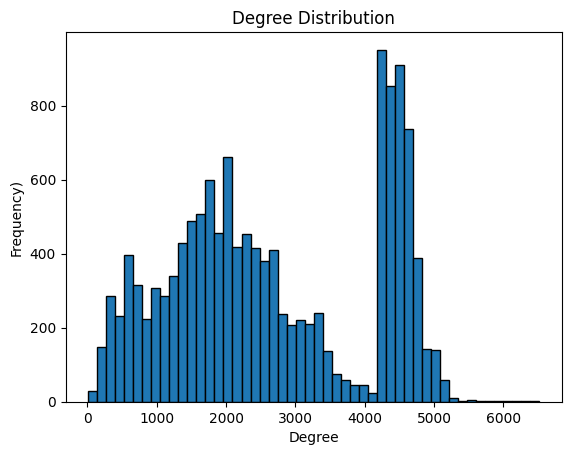

✅ Degree distribution plot for graph displayed.


In [ ]:
print("\n⚙️ Initializing adjacency lists for Unweighted and Weighted graphs...\n")
# Unweighted adjacency list
#output format (start_node, [end_node1, end_node2, ...])
adjacency_list = edges_rdd.groupByKey().mapValues(list)
print("✅ Unweighted adjacency list initialized.")

# Weighted adjacency list
# output format (start_node, [(end_node1, weight1), (end_node2, weight2), ...])
                                                # Mapping to (start_node, (end_node, weight))
adjacency_list_weighted = edges_rdd_weighted_norm.map(lambda x: (x[0], (x[1], x[2]))) \
                                                 .groupByKey().mapValues(list)
print("✅ Weighted adjacency list initialized.") #group by start_node #[(end_node1, weight1), (end_node2, weight2), ...]


adjacency_list_weighted_adjusted = normalized_weights_rdd.map(lambda x: (x[0], (x[1], x[2]))) \
                                                 .groupByKey().mapValues(list)

print("✅ Adjusted Weighted adjacency list initialized.")



print("\n📊 Calculating degree distribution...")
                                    # getting the values
                                    # lenght of each node's adj list
unweighted_degrees = adjacency_list.mapValues(len).values()

# degree statistics
print("🔢 Degree Distribution Statistics:")
print(f"  Min Degree: {unweighted_degrees.min()}")
print(f"  Max Degree: {unweighted_degrees.max()}")
print(f"  Mean Degree: {unweighted_degrees.mean():.2f}")
print(f"  Stddev Degree: {unweighted_degrees.stdev():.2f}")


print("\n📈 Plotting degree distribution...")
unweighted_degrees_collected = unweighted_degrees.collect()
plt.hist(unweighted_degrees_collected, bins=50, edgecolor='k', log=False)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency)")
plt.show()
print("✅ Degree distribution plot for graph displayed.")


### **Checking Graph Assumptions for PageRank**

To ensure the graph is suitable for the PageRank algorithm:

- **Dead Ends**: Nodes with no outgoing edges (empty adjacency lists) were checked.
No dead ends were found, so the graph is ready for PageRank. ✅

- We could also do connectivity check but i couldnt create the network using Spark, maybe next time.



In [ ]:
print("\n🔍 Checking graph assumptions for PageRank...\n")

                                 # counting adjacency lists with length 0
dead_ends = adjacency_list.filter(lambda x: len(x[1]) == 0).count()
print(f"Number of dead-end nodes: {dead_ends}")
if dead_ends > 0:
    print("⚠️ Dead ends detected! Consider handling them in the PageRank algorithm.")
else:
    print("✅ No dead ends in the graph.")




🔍 Checking graph assumptions for PageRank...

Number of dead-end nodes: 0
✅ No dead ends in the graph.


#### **Inputs and Initialization**:
1. **Edge Information (RDD)**: Contains the connections between nodes.
2. **Parameters**:
   - **Iterations**: Maximum number of iterations.
   - **Damping Factor** (\( d \)): Probability of random jump to a link (default \( d = 0.85 \)).
   - **Tolerance**: Threshold for convergence.

   - Assign an **initial** PageRank value to all nodes:
   $$
   PR(Vi) = \frac{1}{N}, \quad \text{where } N = \text{Total Nodes}.
   $$
    For \( N = 13,487 \):
$$
PR(Vi) = \frac{1}{13,487} \approx 0.000074.
$$

These initial values apply to both unweighted and weighted graphs.

In [ ]:
print("\n🔢 Initializing PageRank\n")
# Common Initialization
iterations = 50 #max iterations
damping_factor = 0.85
tolerance = 1e-6  # convergence tolerance
n = row_count # total number of nodes
first_pr_tags = 1 / n  # Initial PageRank value


print(f"✅  PageRank parameters initialized:\n   - Max Iterations: {iterations}\n   - Damping factor: {damping_factor}\n   - Tolerance: {tolerance:.6f}\n")
print(f"✅ Unweighted and Weighted PageRank variables initialized:\n   - Nodes tag-based net: {n}\n   - Initial PageRank for tags based: {first_pr_tags:.6f}\n")
page_ranks = adjacency_list.mapValues(lambda _: first_pr_tags)


🔢 Initializing PageRank

✅  PageRank parameters initialized:
   - Max Iterations: 50
   - Damping factor: 0.85
   - Tolerance: 0.000001

✅ Unweighted and Weighted PageRank variables initialized:
   - Nodes tag-based net: 13487
   - Initial PageRank for tags based: 0.000074



## **Iterative Computation**

### **Step 1: Contributions**
Each node distributes its current PageRank score to its neighbors:

-  **Unweighted Contributions**:
For unweighted graphs, contributions are distributed equally:
$$
\text{Contribution to Neighbor } j = \frac{PR(V_i)}{\text{Number of Neighbors}}.
$$

- **Weighted Contributions**:
For weighted graphs, contributions are scaled by the normalized edge weights:
$$
\text{Contribution to Neighbor } j = PR(V_i) \cdot \text{Weight}(i, j).
$$


#### **Step 2: Update PageRank Values**
After aggregating contributions from neighbors, update the PageRank values using the formula:
$$
PR(V_i) = d \cdot \sum_{V_j \in \text{in-neighbors}(V_i)} \text{Contribution to Neighbor } j + \frac{1 - d}{N}
$$

Explanation:
- \( d \): Damping factor to account for link-following behavior.
- $$\frac{1 - d}{N}\$$ Redistributes scores to simulate random jumps.

### **Step 3: Convergence Check**
At the end of each iteration, the algorithm checks if PageRank values have converged:
1. Compute the Euclidean distance between the old and new PageRank values:
   $$
   \text{Distance} = \sqrt{\sum_{i=1}^N (PR_{\text{new}}(V_i) - PR_{\text{old}}(V_i))^2}.
   $$
2. Stop if:
   $$
   \text{Distance} < \epsilon.
   $$
If the distance is above the tolerance, the algorithm continues to the next iteration.

## **Output**

After completing the iterations:
**Final PageRank Values**:
   - Scores for all nodes, representing their importance in the graph.



In [ ]:
def run_pagerank(adjacency_list,
                 weighted=False,
                 damping_factor = damping_factor,
                 tolerance = tolerance,
                 iterations = iterations,
                 n = n,
                 page_ranks = page_ranks ):
    """
    Executes the PageRank algorithm for a given graph (weighted or unweighted).

    Args:
        page_ranks: RDD containing initial PageRank values as (node_id, PageRank_value).
        adjacency_list: RDD containing adjacency list:
        damping_factor: The damping factor (usually 0.85).
        tolerance: Convergence tolerance for distance.
        iterations: Maximum number of iterations.
        n: Total number of nodes in the graph.
        weighted: Boolean flag to use weighted contribution.

    Returns:
        final_page_ranks: RDD containing the final PageRank values as (node_id, PageRank_value).
    """

    # caching and partitioning adjacency list and initial PageRanks for efficiency
    adjacency_list = adjacency_list.partitionBy(400).cache()
    page_ranks = page_ranks.partitionBy(400).cache()


    print("🔁 Starting PageRank iterations...")
    distance = tolerance + 1  # intializing distance to ensure the loop starts (greater than tolerance)

    for i in range(iterations):
        if distance < tolerance:  # check for convergence
            print(f"✅ Converged after {i} iterations, PageRank computations completed!\n")
            break

        # save the current PageRank values for comparison
        old_page_ranks = page_ranks

        # Calculate contributions to neighbors
    if weighted:
        #       (node_id, PageRank_value)   (node_id, [(neighbor_id1, weight1), (neighbor_id2, weight2), ...])
        contributions = page_ranks.join(adjacency_list).flatMap(

            lambda node_data: #  (node_id, (PageRank_value, [(neighbor_id, weight), ...]))

            [ (neighbor, node_data[1][0] * weight)  # Contribution = PR(node) * weight
                for neighbor, weight in node_data[1][1]  # iterate through each (neighbor, weight)
            ] # output: [(neighbor_id, contribution_value), ()...]
        )
    else:
        # Unweighted PageRank
        #       (node_id, PageRank_value)   (node_id, [neighbor_id1, neighbor_id2, ...])
        contributions = page_ranks.join(adjacency_list).flatMap(
            lambda node_data:     # (node_id, (PageRank_value, [neighbor_id1, neighbor_id2, ...]))

            [  (neighbor, node_data[1][0] / len(node_data[1][1]))  # Contribution = PR(node) / degree(node)
                for neighbor in node_data[1][1]  # Iterate through each neighbor
            ] # output: [(neighbor_id, contribution_value), ()...]
        )

        # comput the new PageRank values
                  #[(node_id1, contribution1), (node_id1, contribution2), ..., (node_id2, contribution1), ...]
        page_ranks = contributions.reduceByKey(
            lambda a, b: a + b  # agg/sum contributions for each node
            ).mapValues(
            lambda pr: damping_factor * pr + (1 - damping_factor) / n  # New PageRank = d * (sum of contributions) + (1 - d) / total_nodes
        )

        # Calculate Euclidean distance to check convergence
        distance = np.sqrt(
           # [(node_id1, (new_PR1, old_PR1)), (node_id2, (new_PR2, old_PR2)), ...]
            page_ranks.join(old_page_ranks)
            .mapValues(lambda x: (x[0] - x[1]) ** 2)  # (new_PR - old_PR)^2 for each node
            .values() # we get the vlues [squared_diff1, squared_diff2, ...]
            .sum()  # sum all of them
        )

        top_nodes = page_ranks.takeOrdered(3, key=lambda x: -x[1])  # top 3 nodes with highest PR scores

        # sum of all PageRank values (should be close to 1)
        pr_sum = page_ranks.values().sum()

        # Display iteration info
        print(f"Iteration {i + 1} - Distance: {distance:.6f}")
        print(f"Top 3 nodes by PageRank (Node, PR Score):")
        for node, score in top_nodes:
            print(f"  Node: {node}, PR Score: {score:.6f}")
        print(f"Sum of PageRank values: {pr_sum:.6f}\n")

    # collecting the final PageRank values after convergence
    final_page_ranks = page_ranks.collect()
    return final_page_ranks


In [ ]:
final_page_ranks_unweighted = run_pagerank(
    adjacency_list=adjacency_list,  # Unweighted adjacency list
    weighted=False  # Use unweighted PageRank
)


🔁 Starting PageRank iterations...
Iteration 1 - Distance: 0.001890
Top 3 nodes by PageRank (Node, PR Score):
  Node: 9414, PR Score: 0.000148
  Node: 2846, PR Score: 0.000138
  Node: 9200, PR Score: 0.000137
Sum of PageRank values: 1.000000

Iteration 2 - Distance: 0.000567
Top 3 nodes by PageRank (Node, PR Score):
  Node: 9200, PR Score: 0.000142
  Node: 10746, PR Score: 0.000142
  Node: 8202, PR Score: 0.000142
Sum of PageRank values: 1.000000

Iteration 3 - Distance: 0.000311
Top 3 nodes by PageRank (Node, PR Score):
  Node: 1731, PR Score: 0.000145
  Node: 9200, PR Score: 0.000145
  Node: 13307, PR Score: 0.000144
Sum of PageRank values: 1.000000

Iteration 4 - Distance: 0.000193
Top 3 nodes by PageRank (Node, PR Score):
  Node: 1731, PR Score: 0.000147
  Node: 9200, PR Score: 0.000146
  Node: 13307, PR Score: 0.000146
Sum of PageRank values: 1.000000

Iteration 5 - Distance: 0.000127
Top 3 nodes by PageRank (Node, PR Score):
  Node: 1731, PR Score: 0.000148
  Node: 13307, PR Score

In [ ]:
final_page_ranks_weighted = run_pagerank(
    adjacency_list=adjacency_list_weighted,  # weighted adjacency list
    weighted=True  # Use weighted PageRank
)


🔁 Starting PageRank iterations...
Iteration 1 - Distance: 0.001941
Top 3 nodes by PageRank (Node, PR Score):
  Node: 2016, PR Score: 0.000140
  Node: 2846, PR Score: 0.000135
  Node: 12223, PR Score: 0.000132
Sum of PageRank values: 1.000000

Iteration 2 - Distance: 0.000555
Top 3 nodes by PageRank (Node, PR Score):
  Node: 2016, PR Score: 0.000144
  Node: 8249, PR Score: 0.000139
  Node: 12223, PR Score: 0.000139
Sum of PageRank values: 1.000000

Iteration 3 - Distance: 0.000295
Top 3 nodes by PageRank (Node, PR Score):
  Node: 2016, PR Score: 0.000144
  Node: 8249, PR Score: 0.000140
  Node: 10345, PR Score: 0.000140
Sum of PageRank values: 1.000000

Iteration 4 - Distance: 0.000186
Top 3 nodes by PageRank (Node, PR Score):
  Node: 2016, PR Score: 0.000143
  Node: 12223, PR Score: 0.000140
  Node: 8249, PR Score: 0.000140
Sum of PageRank values: 1.000000

Iteration 5 - Distance: 0.000128
Top 3 nodes by PageRank (Node, PR Score):
  Node: 2016, PR Score: 0.000142
  Node: 10345, PR Scor

In [ ]:
final_page_ranks_weighted_adjusted = run_pagerank(
    adjacency_list=adjacency_list_weighted_adjusted,  # weighted adjacency list
    weighted=True  # Use weighted PageRank
)


🔁 Starting PageRank iterations...
Iteration 1 - Distance: 0.001995
Top 3 nodes by PageRank (Node, PR Score):
  Node: 5529, PR Score: 0.000136
  Node: 12223, PR Score: 0.000135
  Node: 8249, PR Score: 0.000135
Sum of PageRank values: 1.000000

Iteration 2 - Distance: 0.000527
Top 3 nodes by PageRank (Node, PR Score):
  Node: 5529, PR Score: 0.000144
  Node: 7372, PR Score: 0.000143
  Node: 6652, PR Score: 0.000143
Sum of PageRank values: 1.000000

Iteration 3 - Distance: 0.000262
Top 3 nodes by PageRank (Node, PR Score):
  Node: 7372, PR Score: 0.000145
  Node: 6652, PR Score: 0.000145
  Node: 5529, PR Score: 0.000145
Sum of PageRank values: 1.000000

Iteration 4 - Distance: 0.000160
Top 3 nodes by PageRank (Node, PR Score):
  Node: 7372, PR Score: 0.000146
  Node: 6652, PR Score: 0.000146
  Node: 5529, PR Score: 0.000145
Sum of PageRank values: 1.000000

Iteration 5 - Distance: 0.000109
Top 3 nodes by PageRank (Node, PR Score):
  Node: 7372, PR Score: 0.000146
  Node: 6652, PR Score: 0

In [ ]:
print("🔗 Mapping PageRank values to painting information for all PageRank results...\n")

# create a mapping from node ID to (author, title)
# this dict maps each node ID (painting) to its author and title
nodes_ids_mapping = dict(
    prado_tags_df.select('id', 'author', 'work_title')  # select only needd columns
        .rdd.map(lambda row: (  # transform each row/element into a tuple (id, (author, work_title))
            row['id'],
            (row['author'], row['work_title'])
        ))
        .collect()  # collect into a dict
)

# empty list to store PageRank data combined with metadata (author, title) for each painting
pagerank_info_unweighted = []
pagerank_info_weighted = []
pagerank_info_adjusted_weighted = []

print("\n🔢 Combining PageRank values with painting metadata...\n")

# Unweighted PageRank
for node_id, pr_value in final_page_ranks_unweighted:  # iterate through the PageRank results
    author, title = nodes_ids_mapping[node_id]  # using the mapping to get the author and title for the node ID
    pagerank_info_unweighted.append((node_id, pr_value, author, title))  # appending combined data to the list

# Weighted PageRank
for node_id, pr_value in final_page_ranks_weighted:
    author, title = nodes_ids_mapping[node_id]
    pagerank_info_weighted.append((node_id, pr_value, author, title))

# Adjusted Weighted PageRank
for node_id, pr_value in final_page_ranks_weighted_adjusted:
    author, title = nodes_ids_mapping[node_id]
    pagerank_info_adjusted_weighted.append((node_id, pr_value, author, title))


print("✅ PageRank values successfully combined with painting information!\n")

print("\n📊 Sorting paintings by the Adjusted Weighted PageRank scores...\n")
#we sort by the rank from high to low (descc)
pagerank_info_adjusted_weighted_sorted = sorted(pagerank_info_adjusted_weighted, key=lambda x: x[1], reverse=True)
pagerank_info_weighted_sorted = sorted(pagerank_info_weighted, key=lambda x: x[1], reverse=True)
pagerank_info_unweighted_sorted = sorted(pagerank_info_unweighted, key=lambda x: x[1], reverse=True)

print("✅ Painting information sorted by Adjusted Weighted PageRank!\n")

# seperate DataFrames for each page rank scoreboard
unweighted_df = pd.DataFrame(
    [                                                                                                               #thast why we add the 1
        {"Node ID": node_id, "Author": author, "Title": title, "Unweighted PageRank": pr_value, "Unweighted Rank": rank + 1}
        for rank, (node_id, pr_value, author, title) in enumerate(pagerank_info_unweighted_sorted)
    ]                                                   # start enumerating from 0
)

weighted_df = pd.DataFrame(
    [                                                                                                               #thast why we add the 1
        {"Node ID": node_id, "Author": author, "Title": title, "Weighted PageRank": pr_value, "Weighted Rank": rank + 1}
        for rank, (node_id, pr_value, author, title) in enumerate(pagerank_info_weighted_sorted)
    ]                                                   # start enumerating from 0
)

adjusted_weighted_df = pd.DataFrame(
    [                                                                                                               #thast why we add the 1
        {"Node ID": node_id, "Author": author, "Title": title, "Adjusted Weighted PageRank": pr_value, "Adjusted Weighted Rank": rank + 1}
        for rank, (node_id, pr_value, author, title) in enumerate(pagerank_info_adjusted_weighted_sorted)
    ]                                                   # start enumerating from 0
)

# merge the 3 types
comparison_df = pd.merge(unweighted_df, weighted_df, on=["Node ID", "Author", "Title"], how="outer")
comparison_df = pd.merge(comparison_df, adjusted_weighted_df, on=["Node ID", "Author", "Title"], how="outer")

# Sort Ranks
comparison_df_sorted_by_unw = comparison_df.sort_values(by=["Unweighted Rank", "Weighted Rank", "Adjusted Weighted Rank"], na_position="last")
comparison_df_sorted_by_w = comparison_df.sort_values(by=["Weighted Rank", "Unweighted Rank", "Adjusted Weighted Rank" ], na_position="last")
comparison_df_sorted_by_adjw = comparison_df.sort_values(by=["Adjusted Weighted Rank", "Weighted Rank", "Unweighted Rank"], na_position="last")

🔗 Mapping PageRank values to painting information for all PageRank results...


🔢 Combining PageRank values with painting metadata...

✅ PageRank values successfully combined with painting information!


📊 Sorting paintings by the Adjusted Weighted PageRank scores...

✅ Painting information sorted by Adjusted Weighted PageRank!



In [ ]:
print("🎨 Top 10 Paintings by Unweighted Rank:\n")
comparison_df_sorted_by_unw.head(10)

🎨 Top 10 Paintings by Unweighted Rank:



,Node ID,Author,Title,Unweighted PageRank,Unweighted Rank,Weighted PageRank,Weighted Rank,Adjusted Weighted PageRank,Adjusted Weighted Rank
1731,1731,"Nin y Tudó, José",Retrato mortuorio del periodista Pedro Avial T...,0.000151,1,0.000143,1,0.000133,23
13307,13307,Anónimo,"San Joaquín, Santa Ana y la Virgen Niña",0.000150,2,0.000112,429,0.000120,81
9200,9200,"Sánchez Perrier, Emilio",Berlina tirada por un caballo en Sevilla,0.000149,3,0.000117,173,0.000113,177
9850,9850,"Reynolds, Sir Joshua",Retrato de James Bourdieu,0.000149,4,0.000140,2,0.000130,30
6573,6573,Anónimo (Obra copiada de: El Greco),San Francisco en oración,0.000147,5,0.000110,600,0.000101,1824
9389,9389,"Creti, Donato ?",Estudio de guerrero romano,0.000144,6,0.000100,2403,0.000091,4350
3233,3233,"Hernández Nájera, Miguel",Víspera del Dos de Mayo,0.000141,7,0.000131,15,0.000122,69
5463,5463,"Jover y Casanova, Francisco",Tratado de Cambray,0.000140,8,0.000131,17,0.000123,66
9547,9547,"Oliva y Rodrigo, Eugenio","Cervantes, en sus últimos días, escribe la ded...",0.000139,9,0.000131,16,0.000122,68
8202,8202,"Goya y Lucientes, Francisco de","Academia, figura velada, de perfil, con cesto ...",0.000138,10,0.000120,97,0.000124,61


In [ ]:
print("🎨 Top 10 Paintings by Weighted Rank:\n")
comparison_df_sorted_by_w.head(10)

🎨 Top 10 Paintings by Weighted Rank:



,Node ID,Author,Title,Unweighted PageRank,Unweighted Rank,Weighted PageRank,Weighted Rank,Adjusted Weighted PageRank,Adjusted Weighted Rank
1731,1731,"Nin y Tudó, José",Retrato mortuorio del periodista Pedro Avial T...,0.000151,1,0.000143,1,0.000133,23
9850,9850,"Reynolds, Sir Joshua",Retrato de James Bourdieu,0.000149,4,0.000140,2,0.000130,30
9241,9241,"Anónimo (Obra copiada de: Velázquez, Diego Rod...",Francisco de Ocáriz y Ochoa,0.000130,33,0.000138,3,0.000126,46
2016,2016,"Ribera y Fieve, Carlos Luis de",Busto de Rodrigo Calderón,0.000127,40,0.000137,4,0.000129,35
12223,12223,"Goya y Lucientes, Francisco de",Anotación sobre la boda del artista. Referenci...,0.000132,24,0.000136,5,0.000141,6
8249,8249,"Goya y Lucientes, Francisco de",El sueño de san José o La muerte de san Franci...,0.000132,25,0.000136,6,0.000141,7
10345,10345,"Goya y Lucientes, Francisco de","Virgen con el Niño sentado en su regazo, enmar...",0.000132,26,0.000136,7,0.000141,8
7372,7372,"Goya y Lucientes, Francisco de",Y no hai remedio,0.000121,67,0.000135,8,0.000142,4
6652,6652,"Goya y Lucientes, Francisco de",Estragos de la guerra,0.000121,66,0.000135,9,0.000142,5
11077,11077,Anónimo,Proyecto de decoración arquitectónica para un ...,0.000122,57,0.000135,10,0.000137,12


In [ ]:
print("🎨 Top 10 Paintings by Author-adjusted Weighted Rank:\n")
comparison_df_sorted_by_adjw.head(10)

🎨 Top 10 Paintings by Author-adjusted Weighted Rank:



,Node ID,Author,Title,Unweighted PageRank,Unweighted Rank,Weighted PageRank,Weighted Rank,Adjusted Weighted PageRank,Adjusted Weighted Rank
5529,5529,Anónimo,Retrato de caballero,0.000125,45,0.000132,14,0.000147,1
4896,4896,Anónimo,Luis Vives,0.000120,77,0.000126,31,0.000143,2
5485,5485,Anónimo,Un hijo de Francisco Ramos del Manzano,0.000120,76,0.000126,30,0.000143,3
7372,7372,"Goya y Lucientes, Francisco de",Y no hai remedio,0.000121,67,0.000135,8,0.000142,4
6652,6652,"Goya y Lucientes, Francisco de",Estragos de la guerra,0.000121,66,0.000135,9,0.000142,5
12223,12223,"Goya y Lucientes, Francisco de",Anotación sobre la boda del artista. Referenci...,0.000132,24,0.000136,5,0.000141,6
8249,8249,"Goya y Lucientes, Francisco de",El sueño de san José o La muerte de san Franci...,0.000132,25,0.000136,6,0.000141,7
10345,10345,"Goya y Lucientes, Francisco de","Virgen con el Niño sentado en su regazo, enmar...",0.000132,26,0.000136,7,0.000141,8
2060,2060,Anónimo,Orfeo y los animales,0.000125,44,0.000123,51,0.000140,9
625,625,Anónimo,Estudio de figura femenina arrodillada,0.000118,96,0.000118,147,0.000140,10


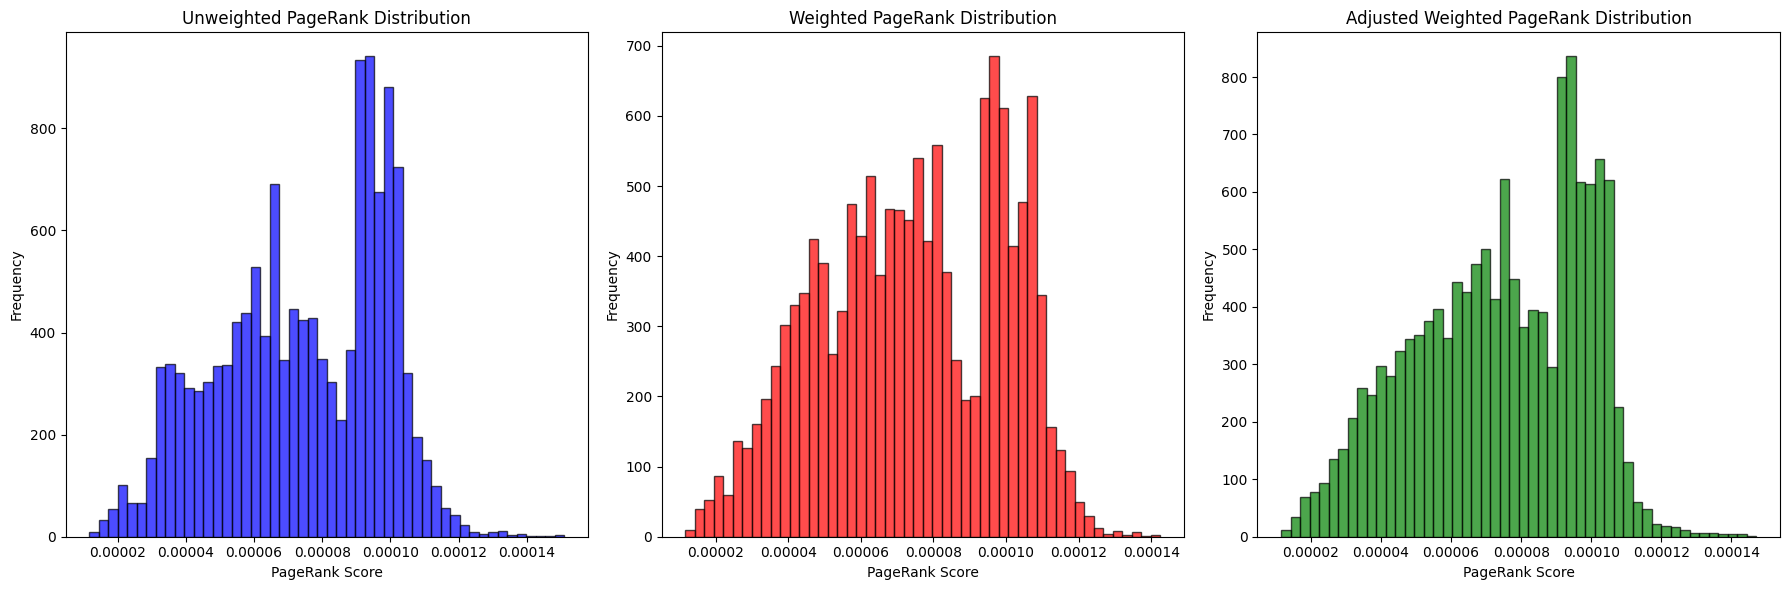

In [ ]:
plt.figure(figsize=(18, 6))

# Unweighted PageRank Distribution
plt.subplot(1, 3, 1)
plt.hist(comparison_df["Unweighted PageRank"], bins=50, edgecolor='k', alpha=0.7, color="blue")
plt.title("Unweighted PageRank Distribution")
plt.xlabel("PageRank Score")
plt.ylabel("Frequency")

# Weighted PageRank Distribution
plt.subplot(1, 3, 2)
plt.hist(comparison_df["Weighted PageRank"], bins=50, edgecolor='k', alpha=0.7, color="red")
plt.title("Weighted PageRank Distribution")
plt.xlabel("PageRank Score")
plt.ylabel("Frequency")

# Adjusted Weighted PageRank Distribution
plt.subplot(1, 3, 3)
plt.hist(comparison_df["Adjusted Weighted PageRank"], bins=50, edgecolor='k', alpha=0.7, color="green")
plt.title("Adjusted Weighted PageRank Distribution")
plt.xlabel("PageRank Score")
plt.ylabel("Frequency")

# Adjust layout for clarity
plt.tight_layout()
plt.show()


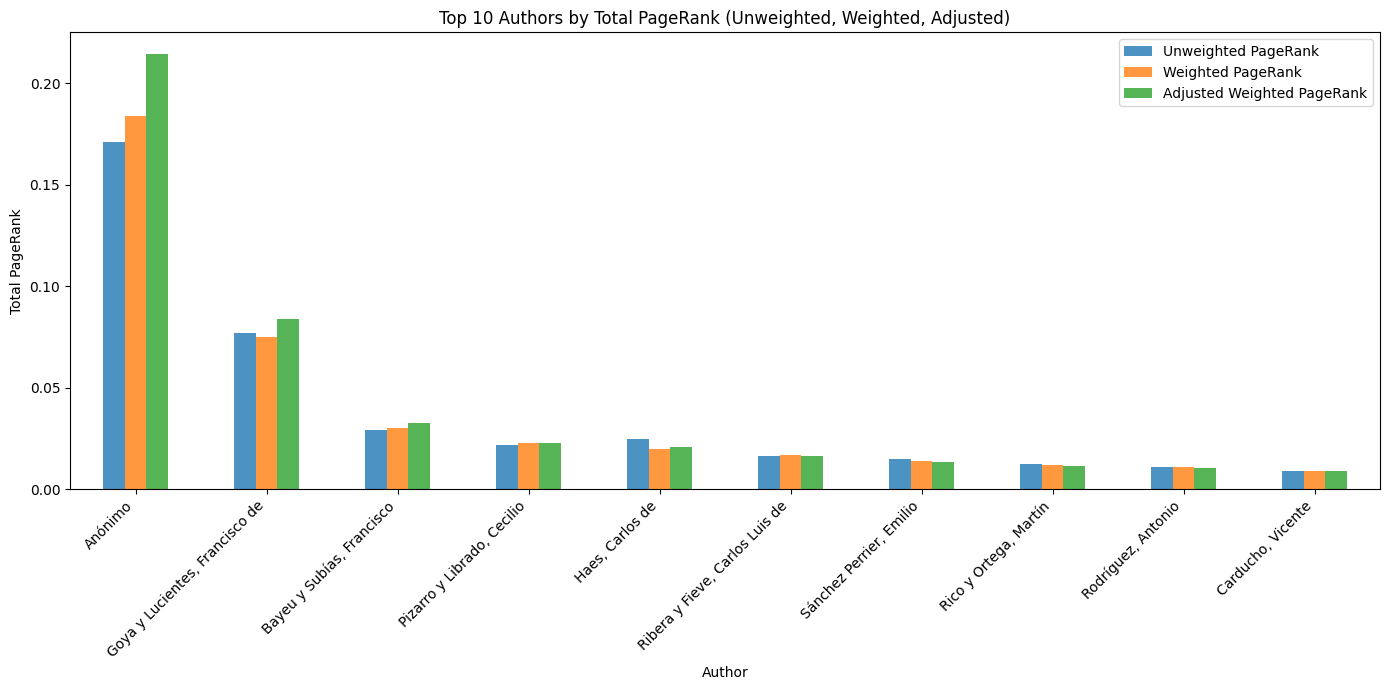

In [ ]:
# Group by Author                                                                                        and sum up the PageRank values
author_ranks = (
    comparison_df.groupby("Author")[["Unweighted PageRank", "Weighted PageRank", "Adjusted Weighted PageRank"]].sum()
    .sort_values(by="Adjusted Weighted PageRank", ascending=False)  # Sort by Adjusted Weighted PageRank
)

# Plot the top 10 authors by Adjusted Weighted PageRank
author_ranks.head(10).plot(kind="bar", figsize=(14, 7), alpha=0.8)
plt.title("Top 10 Authors by Total PageRank (Unweighted, Weighted, Adjusted)")
plt.xlabel("Author")
plt.ylabel("Total PageRank")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




---


# 🎨  **Conclusion**
This PageRank-based system offered a robust framework for ranking paintings based on **connectivity**, **themes**, and **authorship**. By combining these methods, it captures both **artistic value** and **thematic importance**, making it a valuable tool for museums, researchers, and art enthusiasts.



## **Top Highlights**

 **Best Painting Overall**
- **"Retrato mortuorio del periodista Pedro Avial Taracena"** by José Nin y Tudó:  
  - Ranked **1st** in both **Unweighted** and **Weighted PageRank**, showing broad connectivity and thematic importance.
  - Dropped to **23rd** in **Adjusted Weighted PageRank** due to limited shared authorship.

**Best Artist Overall**
- **Francisco de Goya y Lucientes**:  
  - Dominates the **Weighted** and **Adjusted Weighted PageRank** with works like *Y no hai remedio* and *Estragos de la guerra*.  
  - His thematic and artistic influence is consistently highlighted.


##  **Key Insights from each Ranking**

**1. Unweighted PageRank**
- Focuses on **broad connectivity**, emphasizing paintings with many links.  
  - *San Joaquín, Santa Ana y la Virgen Niña* ranks **2nd** but drops in other rankings due to weaker thematic ties.

**2. Weighted PageRank**
- Highlights **thematic depth**, prioritizing paintings with strong shared tags.  
  - *Francisco de Ocáriz y Ochoa* by Anónimo ranks **3rd**, showcasing its rich tag-based connections.

**3. Adjusted Weighted PageRank**
- Combines **themes and authorship**, amplifying influence from artists.  
  - *Retrato de caballero* (by Anónimo) ranks **1st**, while Goya’s paintings shine due to their thematic and artistic strength.


## 🌟 **Future Improvements**

 **Balancing "Anónimo":**

We saw that Anónimo (anonymous artists) dominates the rankings with 2,698 paintings, overshadowing named artists.  

We could adjust its weight to reduce bias and highlight named artists like Goya or Reynolds, but for the sake of simplicity I kept it like this.


**Dynamic Weight Adjustments:**

Use smarter weight adjustments for shared authorship and tags.
could be:

`Adjusted Weight = Base Weight + (Authorship Weight × Influence Score)`

where Influence score is maybe the number of paintings they made.




